<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Авторы материала: Ольга Дайховская, Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://cloud.mail.ru/public/3EJK/cB2VXsyrP). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1ga4KcJdwMWsgEeE76vcTQ34C2iLF7VMhM6nIh_BHUNE).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("D:/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("D:/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("D:/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("D:/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
print(X.shape, y.shape)

(10299, 561) (10299,)


Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)
X_scaled[0:10]

array([[  2.10533854e-01,  -6.87026385e-02,  -4.52194533e-01, ...,
         -6.74432366e-01,   3.82007658e-01,  -1.61505480e-02],
       [  6.02084832e-02,   3.59023537e-02,  -2.75221885e-01, ...,
         -6.81359801e-01,   3.83147865e-01,  -1.20627169e-04],
       [  7.84597052e-02,  -4.64269585e-02,  -8.55480582e-02, ...,
         -6.89470939e-01,   3.84288531e-01,   1.92144041e-02],
       ..., 
       [  4.56226480e-02,  -3.43281966e-01,  -3.09923417e-01, ...,
         -6.93546669e-01,   3.94572269e-01,   4.57758676e-02],
       [  4.35664410e-02,  -1.07934248e-01,  -2.22999684e-01, ...,
         -6.87588865e-01,   4.11609155e-01,   6.29278252e-02],
       [  9.22510060e-02,   2.09640610e-01,   5.39288170e-02, ...,
         -6.88220599e-01,   4.15956303e-01,   7.38865429e-02]])

In [8]:
X_scaled[0:10], X[0:10]

(array([[  2.10533854e-01,  -6.87026385e-02,  -4.52194533e-01, ...,
          -6.74432366e-01,   3.82007658e-01,  -1.61505480e-02],
        [  6.02084832e-02,   3.59023537e-02,  -2.75221885e-01, ...,
          -6.81359801e-01,   3.83147865e-01,  -1.20627169e-04],
        [  7.84597052e-02,  -4.64269585e-02,  -8.55480582e-02, ...,
          -6.89470939e-01,   3.84288531e-01,   1.92144041e-02],
        ..., 
        [  4.56226480e-02,  -3.43281966e-01,  -3.09923417e-01, ...,
          -6.93546669e-01,   3.94572269e-01,   4.57758676e-02],
        [  4.35664410e-02,  -1.07934248e-01,  -2.22999684e-01, ...,
          -6.87588865e-01,   4.11609155e-01,   6.29278252e-02],
        [  9.22510060e-02,   2.09640610e-01,   5.39288170e-02, ...,
          -6.88220599e-01,   4.15956303e-01,   7.38865429e-02]]),
 array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
          0.17994061, -0.05862692],
        [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
          0.18028889, -0

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE)
res = pca.fit(X_scaled)
#pca.explained_variance_ratio_
X_pca = np.cumsum(pca.explained_variance_ratio_) 

In [33]:
pca2 = PCA(0.9, random_state=RANDOM_STATE)
res2 = pca2.fit(X_scaled)

In [34]:
len(res2.components_)

65

In [10]:
X_pca[63], X_pca[64], X_pca[65]

(0.89874145624532076, 0.90048333468229291, 0.90219804332986531)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [1]:
# Ваш код здесь


**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [35]:
X_pca[0], len(X_scaled[0]), pca.explained_variance_ratio_[0], pca2.explained_variance_ratio_[0]


(0.5073822103501332, 561, 0.5073822103501332, 0.5073822103501332)

In [12]:
XComp = pd.DataFrame()
for k in range(65):
    vec = []
    for j in range(len(X_scaled)):
        vec.append(np.inner(X_scaled[j], pca.components_[k]))
    XComp[k] = vec

In [36]:
XComp2 = pd.DataFrame()
for k in range(65):
    vec = []
    for j in range(len(X_scaled)):
        vec.append(np.inner(X_scaled[j], pca2.components_[k]))
    XComp2[k] = vec

In [13]:
comp1 = XComp[0]
comp2 = XComp[1]

In [14]:
len(comp1), len(comp2)
y2  = []
y3 = []
for yy in y:
    if yy in [1,2,3]:
        y2.append(1)
    else:
        y2.append(2)
    if yy == 1:
        y3.append(1)
    elif yy in [2,3]:
        y3.append(2)
    else:
        y3.append(3)
        

Визуализируйте данные в проекции на первые две главные компоненты.

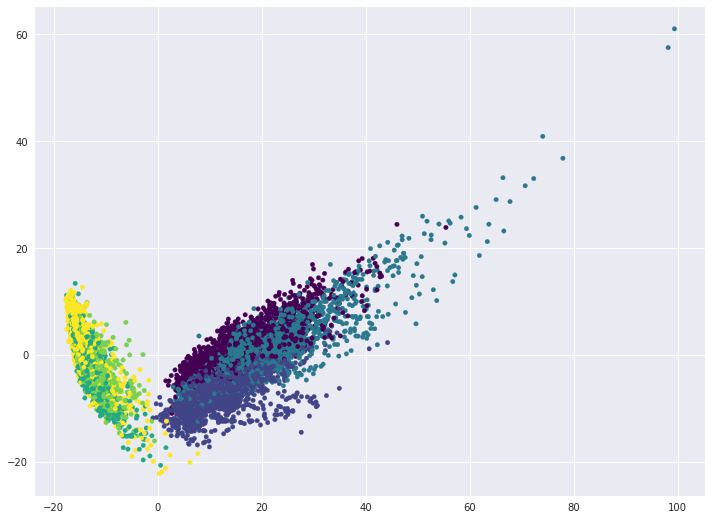

In [15]:
# Ваш код здесь
plt.scatter(comp1, comp2, c=y, s=20, cmap='viridis');

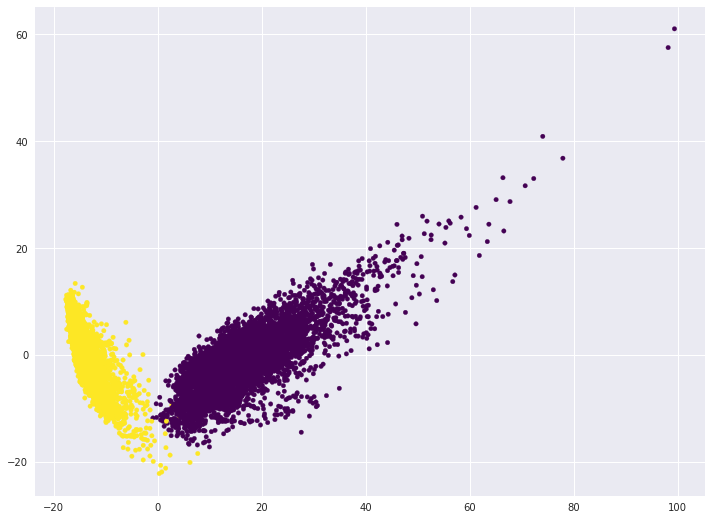

In [16]:
plt.scatter(comp1, comp2, c=y2, s=20, cmap='viridis');

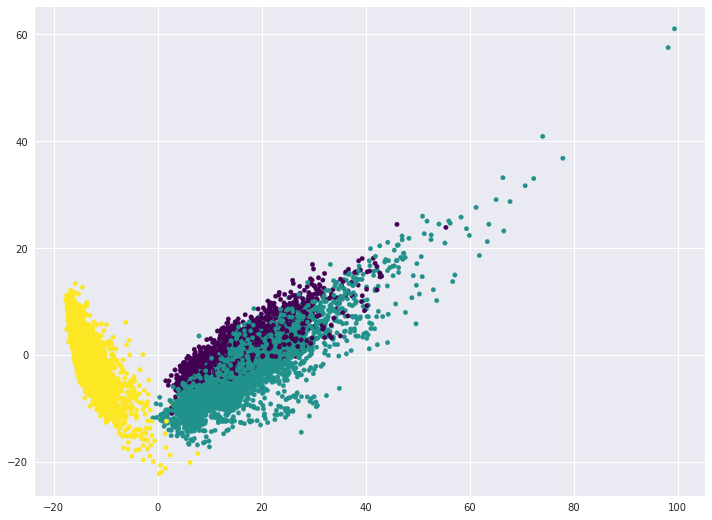

In [17]:
plt.scatter(comp1, comp2, c=y3, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [18]:
# Ваш код здесь
mykmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(XComp)

In [19]:
cluster_labels = mykmeans.labels_
print(XComp.shape)

(10299, 65)


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

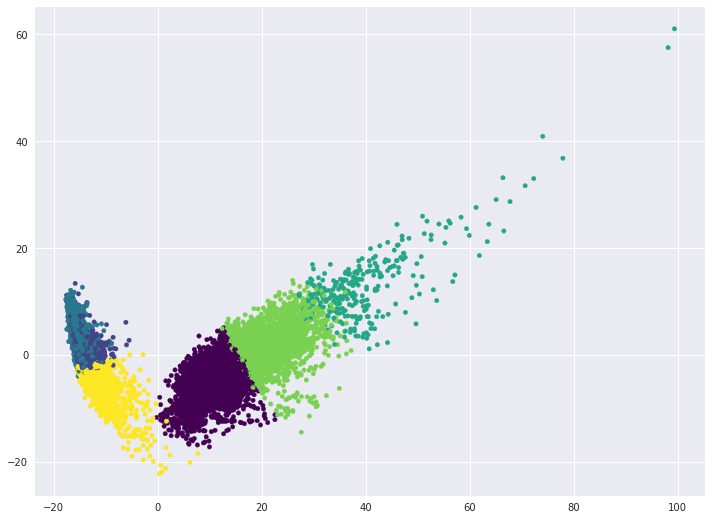

In [20]:
# Ваш код здесь
plt.scatter(comp1, comp2, c=mykmeans.labels_, s=20,  cmap='viridis');

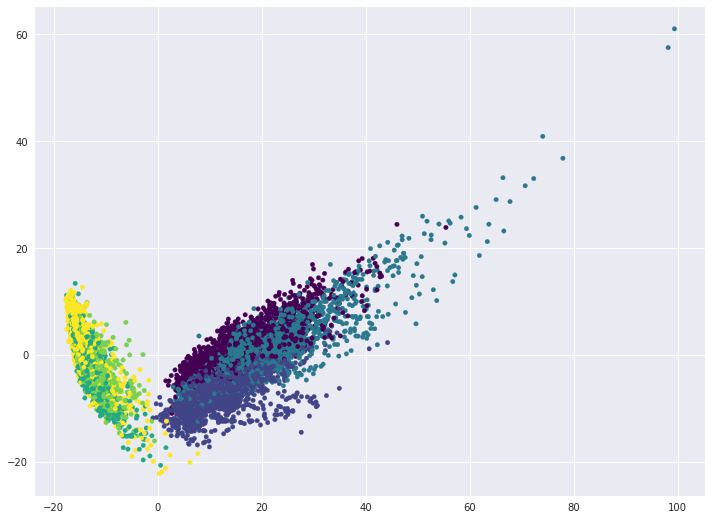

In [21]:
plt.scatter(XComp.iloc[:, 0], XComp.iloc[:, 1], c=y, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [22]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [23]:
mykmeans.inertia_

2003454.7982992898

In [24]:
for ind in tab.index:
    print(ind)
    tabred = tab.loc[ind, :]
    #print(tabred)
    tab1 = tabred[['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']]
    tab2 = tabred['все']
    #print(tab1, tab2)
    print(tab1.max()/tab2)

ходьба
0.524390243902
подъем вверх по лестнице
0.803756476684
спуск по лестнице
0.633001422475
сидение
0.694991558807
стояние
0.705141657922
лежание
0.801440329218
все
0.25546169531


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [25]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    mykmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(XComp)
    inertia.append(mykmeans.inertia_)

In [26]:
inertia
abs(inertia[1]-inertia[2])/abs(inertia[1]-inertia[0]), abs(inertia[2]-inertia[3])/abs(inertia[2]-inertia[1]), abs(inertia[3]-inertia[4])/abs(inertia[3]-inertia[2])

(0.14032949314037022, 0.39628147512086059, 0.90561508478443276)

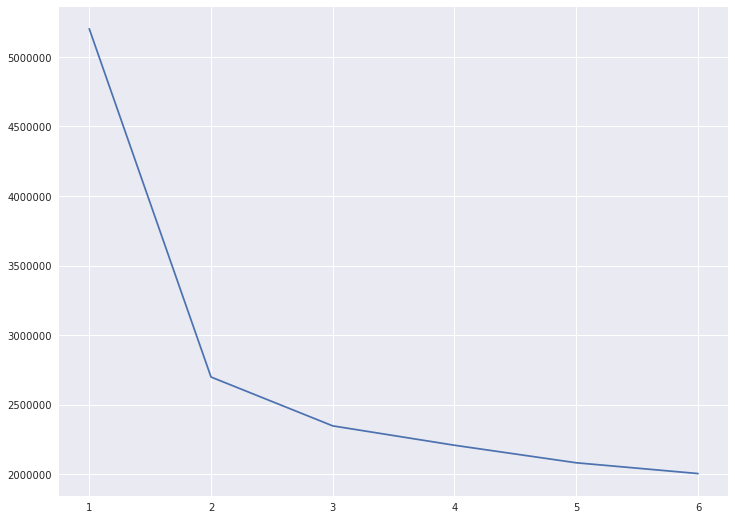

In [27]:
plt.plot(range(1, n_classes+1), inertia)

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [28]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(XComp)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [29]:
metrics.adjusted_rand_score(y, ag.labels_)


0.49362763373004886

In [30]:
mykmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE).fit(XComp)
    
metrics.adjusted_rand_score(y, mykmeans.labels_)   

0.32961067388941928

In [31]:
mykmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(XComp)
    
metrics.adjusted_rand_score(y, mykmeans.labels_) 

0.41980700126023451

In [32]:
metrics.adjusted_rand_score(ag.labels_, mykmeans.labels_)
#metrics.adjusted_rand_score([0, 0, 1, 1], [-1, -1, 1, 1])

0.69148167405637739

In [38]:
import random
myvec = []
for j in range(len(ag.labels_)):
    myvec.append(random.randrange(1, 7))

In [43]:
metrics.adjusted_rand_score(y, myvec)

-1.6022368276994715e-05

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- ARI выражает сходство меток, полученных после кластеризации, с метками классов для одной и той же выборки, и чем больше значение этого индекса, тем лучше
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [45]:
# Ваш код здесь
#
X_train_scaled = scaler.fit_transform(X=X_train)
X_test_scaled = scaler.fit_transform(X=X_test)

In [56]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [59]:
# Ваш код здесь
%time
best_svc = GridSearchCV(svc, svc_params, cv = 3)
best_svc.fit(X_train_scaled, y_train)

Wall time: 0 ns


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [209]:
best_svc.best_params_, best_svc.cv_results_

({'C': 0.1},
 {'mean_fit_time': array([ 2.13233956,  2.20333735,  2.65000431,  2.30933976,  2.28467043]),
  'mean_score_time': array([ 0.00499996,  0.00333333,  0.00566665,  0.00333341,  0.00166663]),
  'mean_test_score': array([ 0.92532644,  0.93620783,  0.9382481 ,  0.92872688,  0.92247008]),
  'mean_train_score': array([ 0.98007341,  0.99075102,  0.99612373,  0.99979597,  0.99945617]),
  'param_C': masked_array(data = [0.001 0.01 0.1 1 10],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}],
  'rank_test_score': array([4, 2, 1, 3, 5]),
  'split0_test_score': array([ 0.93637847,  0.93923328,  0.93515498,  0.91843393,  0.91435563]),
  'split0_train_score': array([ 0.97755102,  0.99      ,  0.99673469,  0.99959184,  1.        ]),
  'split1_test_score': array([ 0.89559543,  0.91721044,  0.92251223,  0.9180261 ,  0.91109299]),
  'split1_train_score': array([ 0.98244898,  0.9922449 ,  0.

In [12]:
# Ваш код здесь

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [210]:
y_predicted = best_svc.predict(X_test_scaled)

In [211]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
               'сидение', 'стояние', 'лежание', 'все']
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


In [46]:
pca2 = PCA(0.9, random_state=RANDOM_STATE)
pca2.fit(X_train_scaled)
X_pca = np.cumsum(pca2.explained_variance_ratio_) 

In [51]:
X_pca[61], X_pca[62]# X_pca[64], X_pca[65]
num = len(X_pca)

In [63]:
compdattrain = pd.DataFrame()
for k in range(num):
    vec = []
    #print(k)
    for j in range(len(X_train_scaled)):
        vec.append(np.inner(X_train_scaled[j], pca2.components_[k]))
    compdattrain[k] = vec
    
compdattest = pd.DataFrame()
for k in range(num):
    vec = []
    #print(k)
    for j in range(len(X_test_scaled)):
        vec.append(np.inner(X_test_scaled[j], pca2.components_[k]))
    compdattest[k] = vec

In [53]:
compdattrain.shape, compdattest.shape

((7352, 63), (2947, 63))

In [64]:
best_svc2 = GridSearchCV(svc, svc_params, cv = 3)
best_svc2.fit(compdattrain, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [65]:
-best_svc2.best_score_+best_svc.best_score_

0.039581066376496166

In [66]:
bsvc1 =metrics.accuracy_score(best_svc.predict(X_test_scaled), y_test)
bsvc2 =metrics.accuracy_score(best_svc2.predict(compdattest), y_test)


In [67]:
bsvc1-bsvc2

0.04479131319986418

In [227]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_train_scaled)

#plt.figure(figsize=(12,10))
#plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
#            edgecolor='none', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))

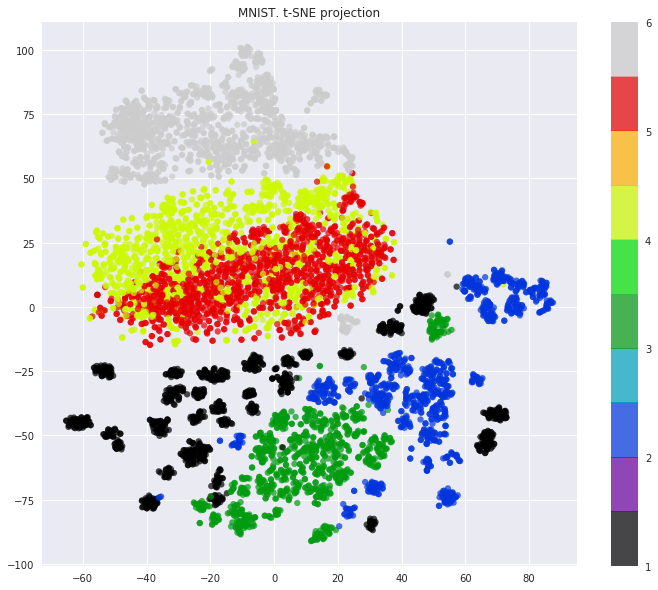

In [228]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

Как видим, задача классификации решается неплохо.

**Вопрос 8:**<br>
Путает ли SVM классы внутри выделенных нами ранее (в задании к 3 вопросу) группах активностей?<br>

**Ответ:**
- да
- нет

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, которые плохо интерпретируются человеком
- SVM работает лучше, чем kMeans, поскольку он алгоритм явно сводится к задаче оптимизации